# Overview



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

In [2]:
# Function to generate inflow and demand data
def generate_data(N, inflow_mean=200, inflow_std=50, correlation_factor=-0.6, lag=1, lag_correlation=0.5):
    np.random.seed(42)
    # Generate inflow data with autocorrelation
    I = np.zeros(N)
    I[0] = np.random.normal(inflow_mean, inflow_std)
    for t in range(1, N):
        I[t] = (1 - lag_correlation) * np.random.normal(inflow_mean, inflow_std) + lag_correlation * I[t - lag]
    
    # Generate negatively correlated demand data
    D_mean = np.mean(I/5)
    noise = np.random.normal(0, inflow_std * 0.2, N)  # Some noise
    D = D_mean + correlation_factor * (I - inflow_mean) + noise
    
    # Ensure neigther inflow or demand is non-negative
    I = np.clip(I, 0, None)
    D = np.clip(D, 0, None)
    return I, D

def calculate_energy_production(R, S, S_max, eta):
    Et = R*eta
    return Et

def plot_simulated_reservoir(I, D, 
                             R_sim, S_sim, max_storage, eta,
                             title = 'Simulated Reservoir Dynamics'):

    # Get energy generation from release data
    E_sim = calculate_energy_production(R_sim, S_sim, max_storage, eta)
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize = (5,5), dpi = 150, sharex=True)

    # Plot inflow
    ax1.plot(np.arange(len(I)), I, label ='Inflow',
             c='royalblue', lw=0.75)
    ax1.plot(np.arange(len(D)), D, label ='Demand',
                c='firebrick', lw=0.75)

    # Plot storage
    ax2.fill_between(np.arange(len(S_sim)), (S_sim/max_storage)*100, 
                     color='cornflowerblue', label='Storage', alpha=0.5, lw=1, ec='royalblue') 
    ax2.hlines(100, 0, len(S_sim), color='k', lw=1, alpha=0.5, ls='--')

    ax2.set_ylabel('Storage (%)')
    ax2.set_ylim(0, 110)
    
    # Plot releases and energy generation
    ax3.plot(np.arange(len(R_sim)), R_sim, 
             c='darkgreen', label='Release', lw=0.75) 
    ax3.plot(np.arange(len(E_sim)), E_sim, 
             c='darkorange', label='Energy Generation', ls='--', lw=0.75)
    
    # Add legend with all labels for all subplots
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.set_xlabel('Time (days)')

    ax1.set_title(title)
    return

In [3]:

def pyomo_lp_reservoir(N, S_min, S_max, R_min, R_max, 
                       eta, I, D,  
                       initial_storage,
                       R_change_limit=None):
    """Uses Pyomo to solve the LP reservoir operation problem.
    
    Parameters
    ----------
    N : int
        Number of time periods to simulate
    S_min : float
        Minimum storage level
    S_max : float
        Maximum storage level
    R_min : float
        Minimum release
    R_max : float
        Maximum release
    eta : float
        Turbine efficiency
    I : array
        Inflow data
    D : array
        Demand data
    initial_storage : float
        Initial storage level
    R_change_limit : float
        Maximum change in release from one time period to the next. Default is None.
    """

    # Model
    model = pyo.ConcreteModel()

    # Time range
    model.T = pyo.RangeSet(0, N-1)  # Time periods

    # Decision Variables
    model.S = pyo.Var(model.T, bounds=(S_min, S_max))  # Storage
    model.R = pyo.Var(model.T, bounds=(R_min, R_max))  # Release

    # Objective Function
    def objective_rule(m):
        return -sum((eta * m.R[t]) + (m.S[t]/S_max*100) for t in m.T)
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    # Constraints
    def S_balance_lower(m, t):
        if t == 0:
            return m.S[t] + m.R[t] <= initial_storage + I[t] - D[t]
        return m.S[t] + m.R[t] <= m.S[t-1] + I[t] - D[t]

    def S_balance_upper(m, t):
        if t == 0:
            return -(m.S[t] + m.R[t]) <= -(initial_storage + I[t] - D[t])
        return -(m.S[t] + m.R[t]) <= -(m.S[t-1] + I[t] - D[t])
    model.S_lower = pyo.Constraint(model.T, rule=S_balance_lower)
    model.S_upper = pyo.Constraint(model.T, rule=S_balance_upper)
    model.S_final = pyo.Constraint(expr=model.S[N-1] == initial_storage)
    
    # limit change in release from one time period to the next
    def R_increase_limit(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.R[t] - m.R[t-1] <= R_change_limit
    def R_decrease_limit(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        return m.R[t-1] - m.R[t] <= R_change_limit

    if R_change_limit is not None:
        model.R_increase = pyo.Constraint(model.T, rule=R_increase_limit)
        model.R_decrease = pyo.Constraint(model.T, rule=R_decrease_limit)

    # Solving the model
    solver = pyo.SolverFactory('scip')
    results = solver.solve(model)

    # Extracting results
    if results.solver.status == pyo.SolverStatus.ok and results.solver.termination_condition == pyo.TerminationCondition.optimal:
        S_opt = np.array([pyo.value(model.S[t]) for t in model.T])
        R_opt = np.array([pyo.value(model.R[t]) for t in model.T])
        return S_opt, R_opt
    else:        
        raise ValueError('Solver did not converge')


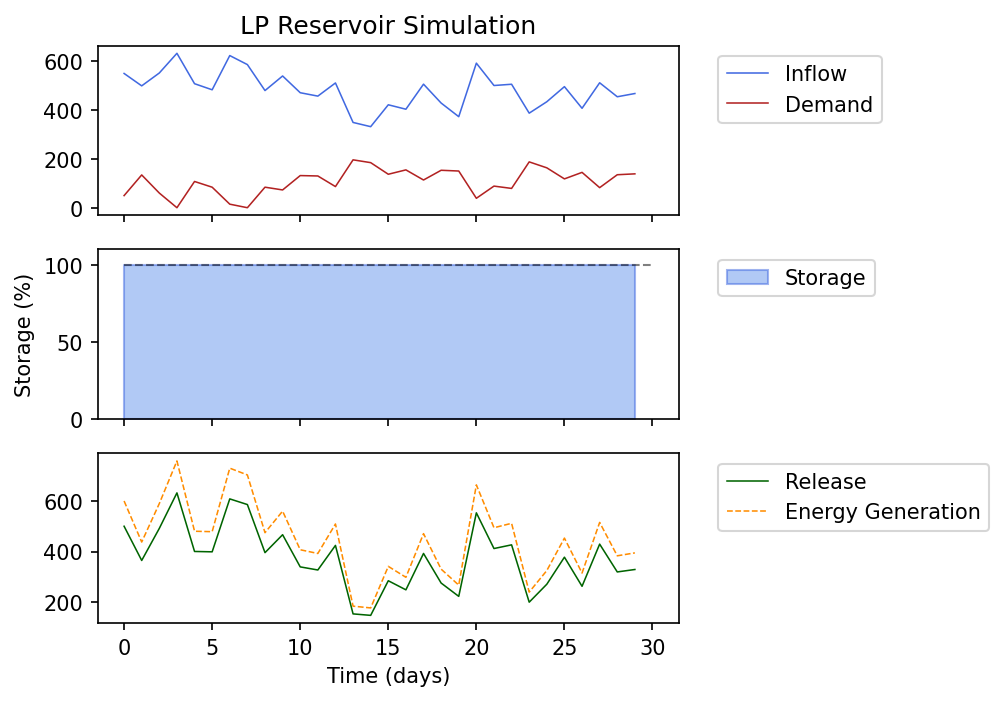

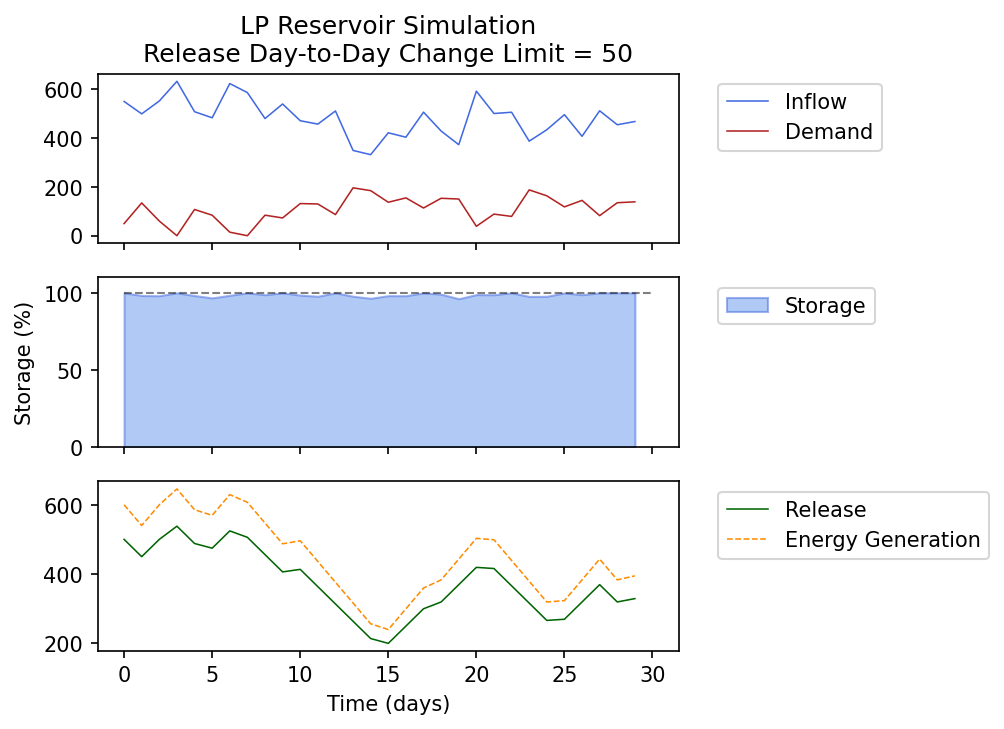

In [4]:
# spcifications
N_t = 30
S_min = 2500
S_max = 5000
R_min = 10
R_max = 1000
eta = 1.2

# Generate simple inflow and demand data
I, D = generate_data(N_t, correlation_factor = -0.70,
                     inflow_mean=500, inflow_std=100,
                     lag_correlation=0.2)


# Run LP operation simulation
S_sim, R_sim = pyomo_lp_reservoir(N_t, S_min, S_max, R_min, R_max, eta, I, D, 
                                  initial_storage=S_max)

# Plot results
plot_simulated_reservoir(I, D,
                         R_sim, S_sim, 
                         S_max, eta=eta,
                         title='LP Reservoir Simulation')

# Run LP operation simulation with release change limit of 50
S_sim, R_sim = pyomo_lp_reservoir(N_t, S_min, S_max, R_min, R_max, eta, I, D, 
                                  initial_storage=S_max,
                                  R_change_limit=50)

# Plot results
plot_simulated_reservoir(I, D,
                         R_sim, S_sim, 
                         S_max, eta=eta,
                         title='LP Reservoir Simulation\nRelease Day-to-Day Change Limit = 50')